In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import cuml

# Setting Matplotlib defaults
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(8,5), dpi=150)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv
/kaggle/input/calories-burnt-prediction/calories.csv


<Figure size 1200x750 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')
org = pd.read_csv('/kaggle/input/calories-burnt-prediction/calories.csv', index_col='User_ID')
org = org.rename(columns={'Gender': 'Sex'})

In [3]:
train = pd.concat([train, org], ignore_index=True)

# Data Understanding

In [4]:
train.shape

(765000, 8)

In [5]:
train.head(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,female,33,166.0,63.0,25.0,107.0,40.5,161.0
9,male,65,185.0,88.0,23.0,104.0,41.0,185.0


In [6]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000
mean,41.447255,174.693126,75.142162,15.423163,95.484672,40.036041,88.307424
std,15.213677,12.854173,14.004122,8.353421,9.452476,0.779863,62.396760
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [7]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [8]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  object
 1   Age         765000 non-null  int64
 2   Height      765000 non-null  float64
 3   Weight      765000 non-null  float64
 4   Duration    765000 non-null  float64
 5   Heart_Rate  765000 non-null  float64
 6   Body_Temp   765000 non-null  float64
 7   Calories    765000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 47.4+ MB


# Data Preprocessing

## Reducing memory usage

In [9]:
train['Age'] = train['Age'].astype('int8')
test['Age'] = test['Age'].astype('int8')

In [10]:
num_cols = test.select_dtypes(include='float64').columns
for col in num_cols:
    train[num_cols] = train[num_cols].astype('float32')
    test[num_cols] = test[num_cols].astype('float32')

In [11]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  object
 1   Age         765000 non-null  int8
 2   Height      765000 non-null  float32
 3   Weight      765000 non-null  float32
 4   Duration    765000 non-null  float32
 5   Heart_Rate  765000 non-null  float32
 6   Body_Temp   765000 non-null  float32
 7   Calories    765000 non-null  float64
dtypes: float32(5), float64(1), int8(1), object(1)
memory usage: 27.7+ MB


In [12]:
mapping = {'male': 1, 'female': 0}

train['Sex'] = train['Sex'].map(mapping).astype('int8')
test['Sex'] = test['Sex'].map(mapping).astype('int8')

In [13]:
features = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [14]:
def add_features(df):
    for i, c1 in enumerate(features):
        for c2 in (features[i+1:]):
            m = f'{c1}*{c2}'
            df[m] = df[c1] * df[c2]
            a = f'{c1}+{c2}'
            df[a] = df[c1] + df[c2]
            s = f'{c1}-{c2}'
            df[s] = df[c1] - df[c2]
            d = f'{c1}/{c2}'
            df[d] = df[c1] / (df[c2] + 1e-3)
            rd = f'{c2}/{c1}'
            df[rd] = df[c2] / (df[c1] + 1e-3)
    return df

In [15]:
def feature_engineer(df):
    
    df['BMI'] = df['Weight'] / (df['Height']/100) ** 2
    
    Max_Heart_Rate = 207 - (0.7 * df['Age'])
    df['HR_Ratio'] = df['Heart_Rate'] / Max_Heart_Rate
    df['HR_Reserve'] =  df['HR_Ratio'] * df['Duration']
    df['Thermal_Load'] = df['Body_Temp'] * df['Duration'] * df['HR_Ratio']

    df['Anaerobic_Contribution'] = df['HR_Ratio']**2 * np.minimum(df['Duration'], 180) * df['Weight'] * 0.05
    df['Aerobic_Contribution'] = (1 - df['HR_Ratio']) * df['Duration'] * df['Weight'] * 0.1
    
    MET_Estimate = (df['Heart_Rate'] / Max_Heart_Rate) * 15
    df['MET_Calories_Rate'] = MET_Estimate * 3.5 * df['Weight'] / 200
    
    df['EPOC_Factor'] = df['HR_Ratio']**2 * np.log1p(df['Duration']/10)
    df['MET_Calories_Total'] = df['MET_Calories_Rate'] * df['Duration']
    
    df['Exercise_Intensity_Index'] = df['Heart_Rate'] * df['Body_Temp'] / (df['Weight'] * df['Age'])
    df['Exercise_Economy'] = df['Heart_Rate'] / (df['Weight']**0.75)

    df['Exertion_score'] = df['Duration'] * df['Heart_Rate'] * df['Body_Temp']
    df['Age_Adjusted_Exertion'] = df['Exertion_score'] / (1 + 0.01 * (df['Age'] - 30))

    for col in ['Duration', 'Heart_Rate', 'Body_Temp']:
        df[f'Sqrt_{col}'] = np.sqrt(df[col])
        df[f'Log_{col}'] = np.log1p(df[col])
        df[f'Square_{col}'] = np.square(df[col])
        df[f'Cube_{col}'] = df[col] ** 3
    
    df['body_theta'] = np.arctan2(df['Weight'], df['Height'])

    df['CB_Proxy'] = np.where(
        df['Sex'] == 'female',
        df['Duration'] * (0.4472 * df['Heart_Rate'] - 0.1263 * df['Weight'] + 0.074 * df['Age'] -  55.0969) / 4.184,
        df['Duration'] * (0.6309 * df['Heart_Rate'] - 0.1988 * df['Weight'] + 0.2017 * df['Age'] -  55.0969) / 4.184,
    )

    df['BMR'] = np.where(
        df['Sex'] == 'female',
        10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161,
        10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
    )
    df['TSI'] = 5 * ((df['Body_Temp'] - 36.5) / (41.5 - 36.5)) + 5 * ((df['Heart_Rate'] - 60) / ((220 - df['Age']) - 60))
    df['AWI'] = (df['Duration'] * df['HR_Ratio']) / df['Age']
    df['RPE'] = df['HR_Ratio'] + 0.1 * (df['Body_Temp'] - 37)
    df['HR_Sigmoid'] = 1 / (1 + np.exp(-0.1 * (df['Heart_Rate'] - 130)))
    df['Duration_Exp_Decay'] = 1 - np.exp(-0.1 * df['Duration'])

    df['Allometric_Energy'] = df['Duration'] * df['Heart_Rate'] * (df['Weight']**0.75)

    df['RMR_MifflinStJeor'] = (10 * df['Weight']) + (6.25 * df['Height']) - (5 * df['Age']) + 5
        
    df['Temp_Efficiency'] = (df['Body_Temp'] - 36.5) / df['HR_Ratio']
    
    df['CV_Strain'] = df['Heart_Rate'] * df['Duration'] * df['Body_Temp'] / (df['Weight'] * df['Height'])
    df['BSA'] = np.sqrt((df['Height'] * df['Weight']) / 3600)

    df['Est_BodyFat_Pct'] = (1.39 * df['BMI']) + (0.16 * df['Age']) - 14

    df['Est_FFM'] = df['Weight'] * (1 - df['Est_BodyFat_Pct']/100)
        
    
    df['VO2_Proxy'] = np.where(
        df['Sex'] == 'female',
        (0.85 * df['Duration']) / (df['HR_Ratio'] * df['Age']),
        (1.00 * df['Duration']) / (df['HR_Ratio'] * df['Age']),
)
    
    return df

In [16]:
def add_statistical_features(df, features):
    df_new = df.copy()
    df_new["row_mean"] = df[features].mean(axis=1)
    df_new["row_max"] = df[features].max(axis=1)
    df_new["row_min"] = df[features].min(axis=1)
    df_new["row_median"] = df[features].median(axis=1)
    df_new["row_skew"] = df[features].skew(axis=1)
    
    return df_new

In [17]:
X = train.copy()
y = X.pop('Calories')
y = np.log1p(y) 
X = add_features(X)
X = feature_engineer(X)
X = add_statistical_features(X, features=features)
X['Sex'] = X['Sex'].astype('category')

X_test = test.copy()
X_test = add_features(X_test)
X_test = feature_engineer(X_test)
X_test = add_statistical_features(X_test, features=features)
X_test['Sex'] = X_test['Sex'].astype('category')

n_folds = 5

In [18]:
corr_matrix = pd.DataFrame(X).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [19]:
X.head()

,Sex,Age,Height,Duration,Heart_Rate,Body_Temp,Sex*Age,Sex/Age,Age/Sex,Sex*Duration,Sex/Duration,Duration/Sex,Sex+Body_Temp,Sex-Body_Temp,Age+Height,Age-Height,Height/Age,Age*Duration,Age+Duration,Age-Duration,Age/Duration,Duration/Age,Heart_Rate/Age,Height-Weight,Height+Duration,Height-Duration,Height/Duration,Height*Heart_Rate,Height/Heart_Rate,Duration-Heart_Rate,BMI,HR_Ratio,Exercise_Intensity_Index,CB_Proxy,BMR,HR_Sigmoid,Temp_Efficiency,Est_BodyFat_Pct,row_median,row_skew
0,1,36,189.0,26.0,101.0,41.000000,36,0.027777,35.964036,26.0,0.038460,25.974026,42.000000,-40.000000,225.0,-153.0,5.249854,936.0,62.0,10.0,1.384562,0.722202,2.805478,107.0,215.0,163.0,7.268951,19089.0,1.871269,-75.0,22.955685,0.555556,1.402778,-2.587548,2082.25,0.052154,8.100000,23.668401,41.000000,1.280969
1,0,64,163.0,8.0,85.0,39.700001,0,0.000000,64000.000000,0.0,0.000000,8000.000000,39.700001,-39.700001,227.0,-99.0,2.546835,512.0,72.0,56.0,7.999000,0.124998,1.328104,103.0,171.0,155.0,20.372452,13855.0,1.917624,-77.0,22.582710,0.524044,0.878776,-0.936135,1559.75,0.010987,6.106354,27.629967,60.000000,1.061985
2,0,51,161.0,7.0,84.0,39.799999,0,0.000000,51000.000000,0.0,0.000000,7000.000000,39.799999,-39.799999,212.0,-110.0,3.156801,357.0,58.0,44.0,7.284674,0.137252,1.647027,97.0,168.0,154.0,22.996716,13524.0,1.916644,-77.0,24.690405,0.490368,1.024265,-7.591922,1652.25,0.009952,6.729641,28.479664,51.000000,1.125036
3,1,20,192.0,25.0,105.0,40.700001,20,0.049998,19.980020,25.0,0.039998,24.975025,41.700001,-39.700001,212.0,-172.0,9.599520,500.0,45.0,-5.0,0.799968,1.249938,5.249738,102.0,217.0,167.0,7.679693,20160.0,1.828554,-80.0,24.414062,0.544041,2.374167,-16.195023,2005.00,0.075858,7.720001,23.135547,40.700001,1.171192
4,0,38,166.0,25.0,102.0,40.599998,0,0.000000,38000.000000,0.0,0.000000,25000.000000,40.599998,-40.599998,204.0,-128.0,4.368306,950.0,63.0,13.0,1.519939,0.657877,2.684140,105.0,191.0,141.0,6.639735,16932.0,1.627435,-77.0,22.136740,0.565410,1.786540,28.637061,1718.50,0.057324,7.251370,22.850067,40.599998,1.193588


In [20]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from cuml.metrics import mean_squared_log_error

bins = KBinsDiscretizer(n_bins=12, encode='ordinal', strategy='kmeans')
duration_bins = bins.fit_transform(train[['Duration']]).astype(int).flatten()

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=100)
oof_cat = np.zeros(len(y))
test_cat = np.zeros(len(X_test))

params = {
    'iterations': 3000, 
    'learning_rate': 0.03813511357889326, 
    'depth': 9, 
    'l2_leaf_reg': 5.101121281815585, 
    'bagging_temperature': 0.6263562727371863, 
    'random_strength': 0.6489211175248135,
    'loss_function': 'RMSE',
    'cat_features': ['Sex'],
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 100,
    'verbose': 0,
    'random_seed': 100,
    'task_type': 'GPU'   
}

for fold, (train_index, valid_index) in enumerate(skf.split(X, duration_bins), start=1):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        cat = CatBoostRegressor(**params).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], use_best_model=True)
    
        valid_pred = cat.predict(X_valid)
        oof_cat[valid_index] = valid_pred
        test_cat += cat.predict(X_test) / n_folds
    
        fold_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(valid_pred)))
        print(f"Fold {fold} RMSE: {fold_rmsle:.6f}")

test_cat = np.expm1(test_cat)
test_cat = np.clip(test_cat, 1, 314)

overall_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(oof_cat)))
print(f"\nOverall OOF RMSLE: {overall_rmsle:.6f}")

Fold 1 RMSE: 0.059957
Fold 2 RMSE: 0.058728
Fold 3 RMSE: 0.058973
Fold 4 RMSE: 0.058422
Fold 5 RMSE: 0.059408

Overall OOF RMSLE: 0.059100


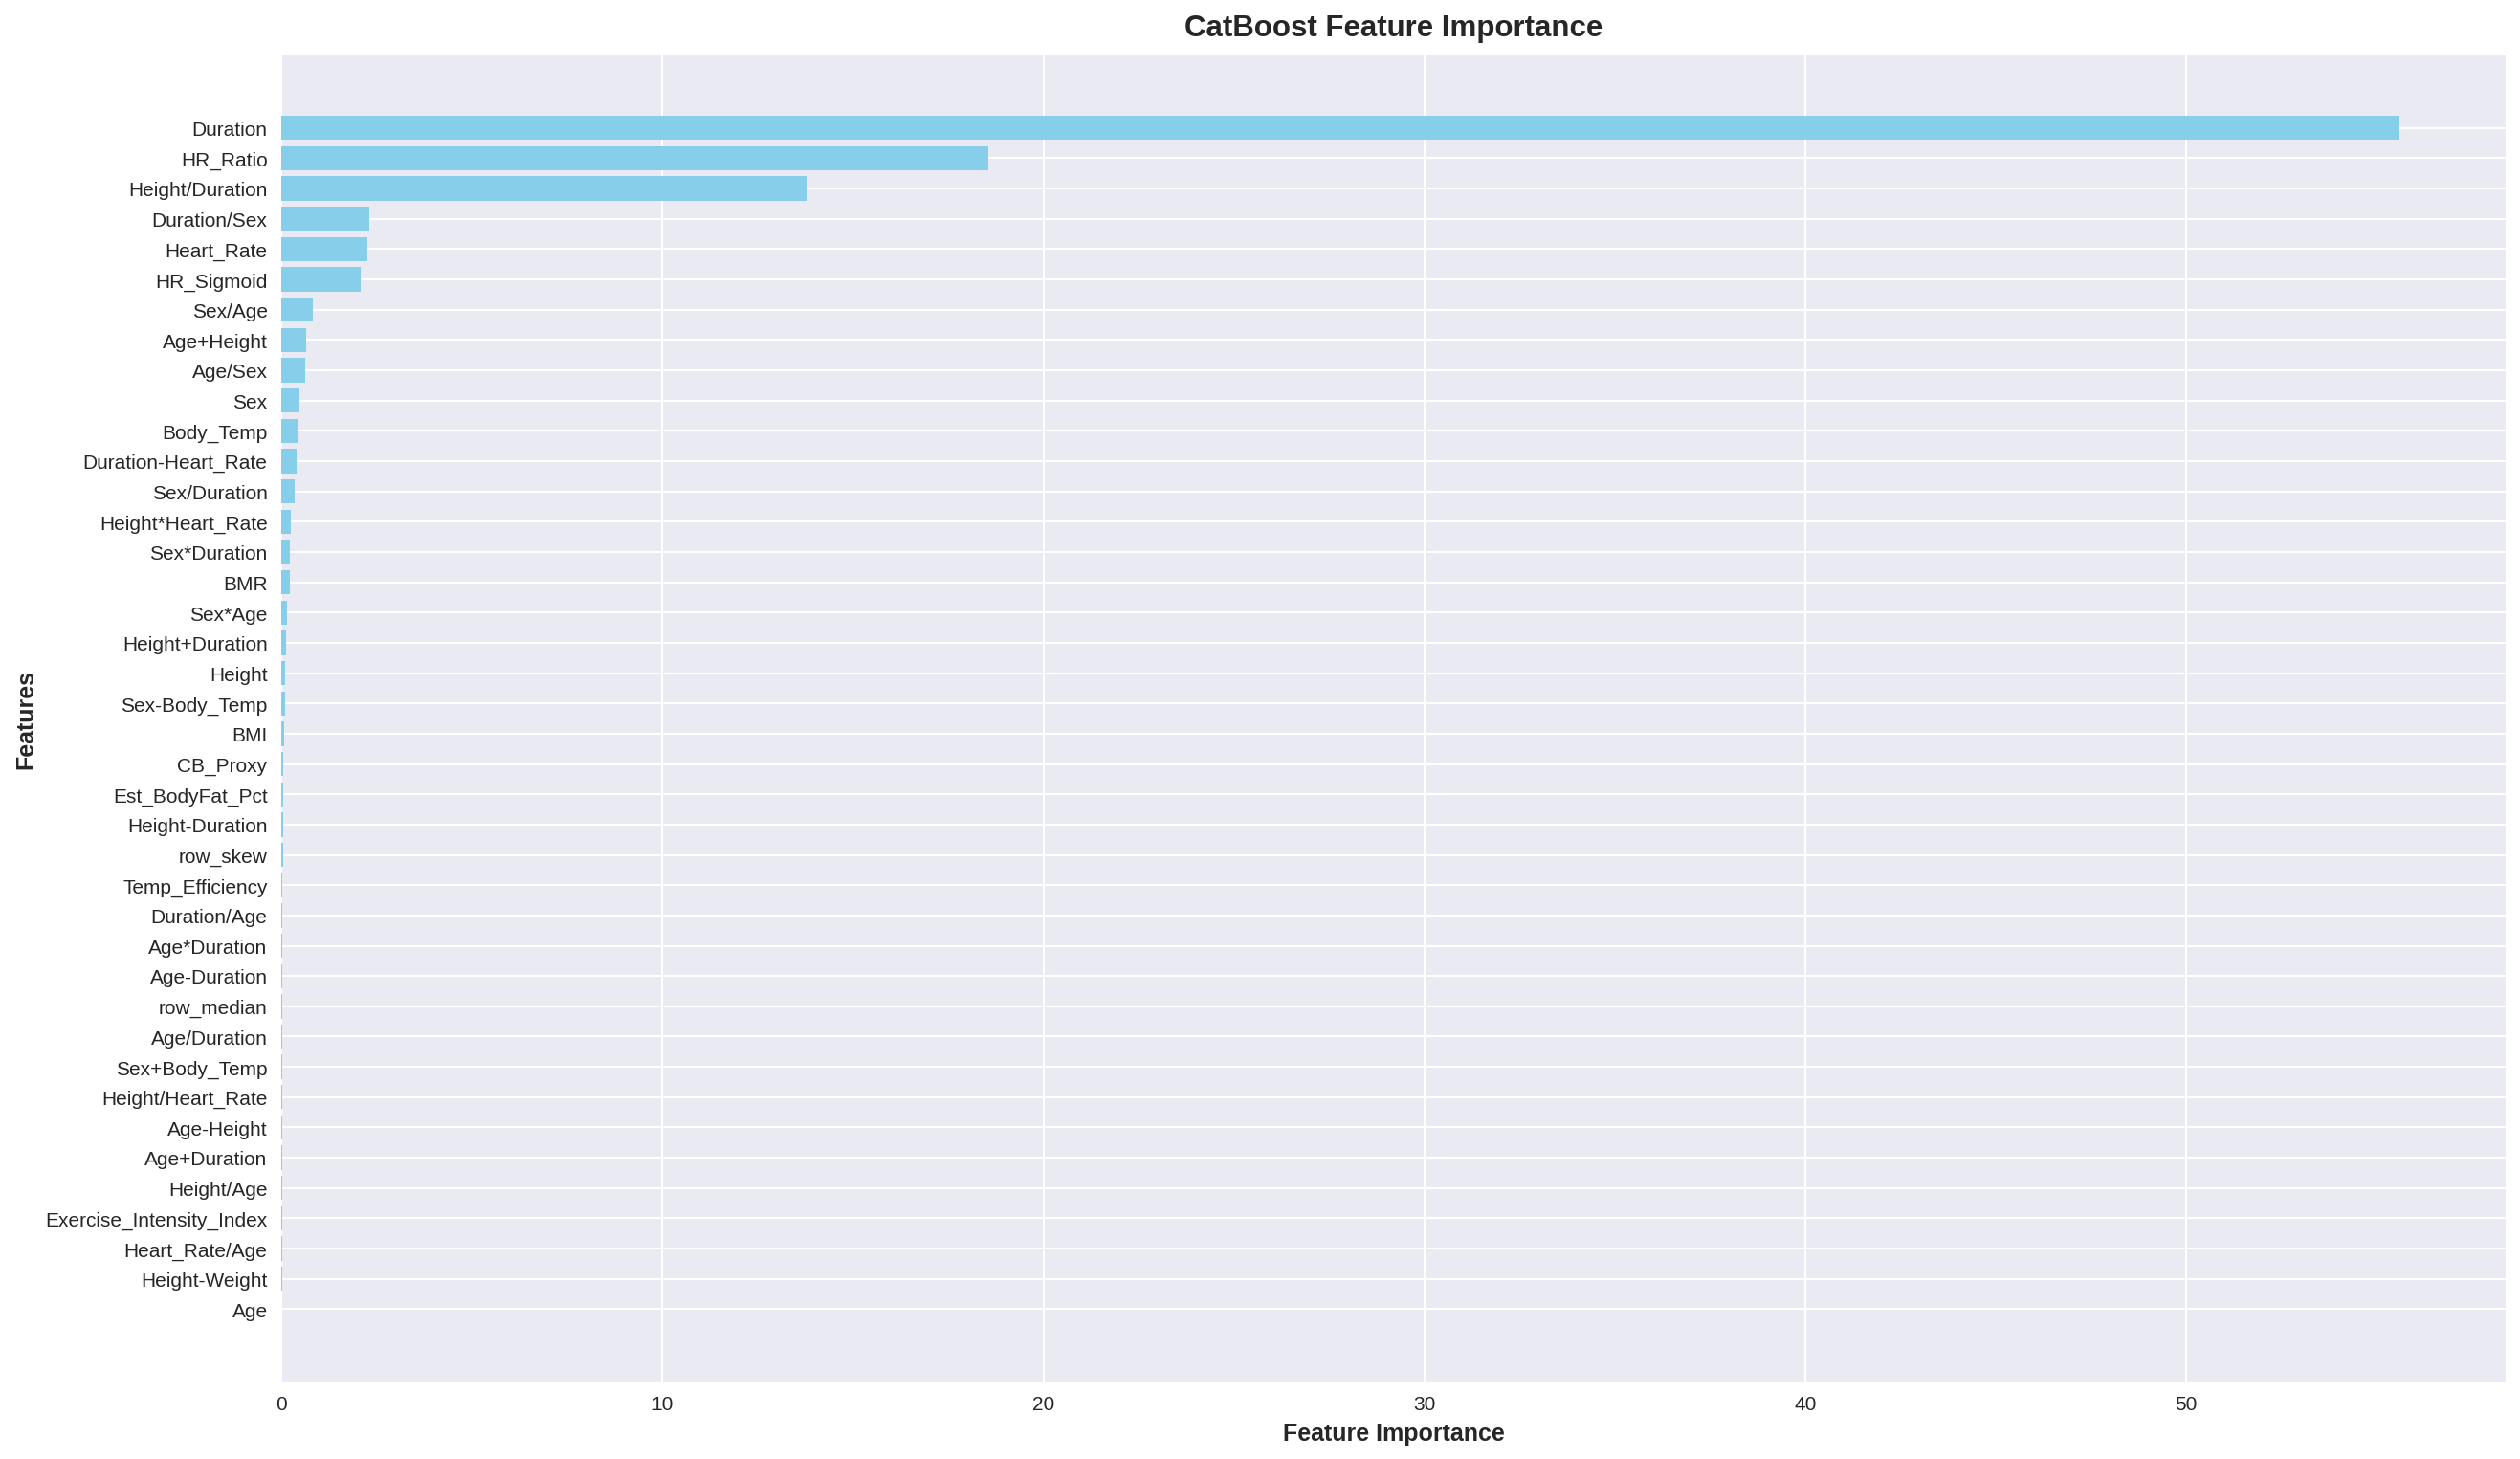

In [21]:
importances = cat.get_feature_importance()
columns = X.columns
df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 12))
plt.barh(df_importances['Feature'], df_importances['Importance'], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [22]:
out_path_oof = "/kaggle/working/oof_cat.pkl"
joblib.dump(oof_cat, out_path_oof)

out_path_test = "/kaggle/working/test_cat.pkl"
joblib.dump(test_cat, out_path_test)

print(f"OOF predictions saved to: {out_path_oof}")

OOF predictions saved to: /kaggle/working/oof_cat.pkl


In [23]:
np.save(f"oof_cat",oof_cat)
np.save(f"test_cat",test_cat)

In [24]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sub['Calories'] = test_cat
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(sub.head(5))

Your submission was successfully saved!
       id    Calories
0  750000   27.273269
1  750001  108.304722
2  750002   87.871981
3  750003  124.902960
4  750004   75.644321
